In [1]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ims1 = 200
tts = 0.1
hu = 750
rel = 1

In [3]:
# Importing images

def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        img = Image.open(filename,'r')
        img = img.resize((ims1,ims1))
        img = np.array(img)
        IMG = img.ravel()
        sample.append(IMG)
    return sample

# all
path11 = 'C-NMC_Leukemia/training_data/fold_0/all/*.bmp'
path21 = 'C-NMC_Leukemia/training_data/fold_1/all/*.bmp'
path31 = 'C-NMC_Leukemia/training_data/fold_2/all/*.bmp'

# hem
path12 = 'C-NMC_Leukemia/training_data/fold_0/hem/*.bmp'
path22 = 'C-NMC_Leukemia/training_data/fold_1/hem/*.bmp'
path32 = 'C-NMC_Leukemia/training_data/fold_2/hem/*.bmp'

n1 = importing_data(path11)
print("n1 done, size  = ", len(n1))
n2 = importing_data(path21)
print("n2 done, size  = ", len(n2))
n3 = importing_data(path31)
print("n3 done, size  = ", len(n3))

y1 = importing_data(path12)
print("y1 done, size  = ", len(y1))
y2 = importing_data(path22)
print("y2 done, size  = ", len(y2))
y3 = importing_data(path32)
print("y3 done, size  = ", len(y3))

train_n = []
train_y = []

for i in n1:
    train_n.append(i)
for i in n2:
    train_n.append(i)
for i in n3:
    train_n.append(i)

for i in y1:
    train_y.append(i)
for i in y2:
    train_y.append(i)
for i in y3:
    train_y.append(i)

n1 done, size  =  2397
n2 done, size  =  2418
n3 done, size  =  2457
y1 done, size  =  1130
y2 done, size  =  1163
y3 done, size  =  1096


In [4]:
df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})

In [5]:
# Combining the data
train_data = df_train_n.append(df_train_y,ignore_index=True)

/var/folders/yv/kbb9q2f16z755yyqqbfpb7b00000gn/T/ipykernel_61085/2440137039.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = df_train_n.append(df_train_y,ignore_index=True)


In [6]:
# Ignoring images that are oddly shaped to avoid outliers
c = 1
igs = []
for i in range(len(train_data)):
    if(len(train_data.image[i])!=(3*ims1*ims1)):
#         print(c,i)
        c = c + 1
        igs.append(i)
# print(igs)
print(len(igs))

0


In [7]:
train_data=train_data.drop(igs,axis=0)

In [8]:
x_train = []
for tdim in train_data.image:
    x_train.append(tdim)
y_train = np.array(train_data.label)

In [9]:
y_traind = []
for i in range(len(y_train)):
    if(y_train[i]=="Healthy"):
        y_traind.append(0)
    else:
        y_traind.append(1)
print(len(y_traind))

10661


In [10]:
x_traind = np.array(x_train)

In [11]:
# One hot encoding
CLASSES = 2
y_train = np.zeros([len(y_traind), CLASSES])
for i in range(len(y_traind)):
        y_train[i][y_traind[i]] = 1

In [12]:
# Test train splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_traind, y_train, test_size=tts)
print('Train size: {train}, Test size: {test}'.format(train=len(x_train), test=len(x_test)))

Train size: 9594, Test size: 1067


In [13]:
# Changing to Matrix format
x_train=np.matrix(x_train)
x_test=np.matrix(x_test)
y_train=np.matrix(y_train)
y_test=np.matrix(y_test)

In [14]:
# Starting to build ELM model
INPUT_LENGTH = x_train.shape[1]
HIDDEN_UNITS = hu #hidden units

Win = np.random.normal(size=[INPUT_LENGTH, HIDDEN_UNITS])
Win = np.matrix(Win)
print('Input Weight shape: {shape}'.format(shape=Win.shape))

Input Weight shape: (120000, 750)


In [15]:
def input_to_hidden(x):
    print("shape of x:",x.shape)
    print("weights shape:",Win.shape)
    a = np.dot(x, Win)
    a = np.maximum(a, rel, a) # ReLU activation
    return a

In [16]:
X = input_to_hidden(x_train)
Xt = np.transpose(X)

shape of x: (9594, 120000)
weights shape: (120000, 750)


In [17]:
# Moore-Penrose pseudo inverse

www1 = np.dot(Xt, X)

b = np.identity(len(np.array(www1)))
b = np.dot(b,3)

www1 = www1 + b
ww1 = np.linalg.inv(www1)
ww2 = np.dot(Xt, y_train)

Wout = np.dot(ww1, ww2)
print('Output weights shape: {shape}'.format(shape=Wout.shape))

Output weights shape: (750, 2)


In [18]:
def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout)
    return y

In [19]:
# Prediction
y = predict(x_test)
correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test = np.argmax(y_test[i])
    correct = correct + (1 if predicted == test else 0)
print('Accuracy: {:f}'.format(correct*100/total))

shape of x: (1067, 120000)
weights shape: (120000, 750)
Accuracy: 81.162137


shape of x: (1067, 120000)
weights shape: (120000, 750)


<Axes: >

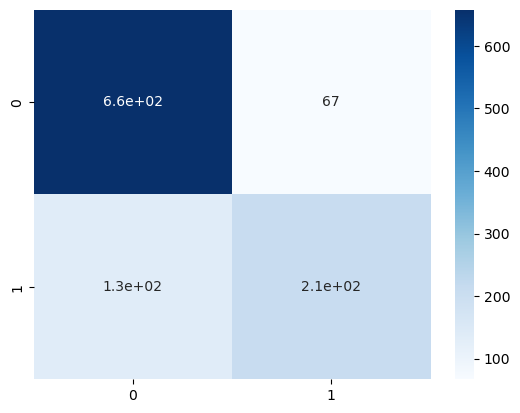

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already trained and tested your model
y_pred = predict(x_test)
y_true = y_test.argmax(axis=1) # convert true labels to categorical format
cm = confusion_matrix(y_true, y_pred.argmax(axis=1))

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')



In [27]:
#IGNOR THIS BLOCK

from tensorflow import keras

# Define a simple model
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(120000,), activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on some data
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
300/300 [==============================] - 4s 12ms/step - loss: 5.4378 - accuracy: 0.6843 - val_loss: 0.6427 - val_accuracy: 0.6795
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6326 - accuracy: 0.6824 - val_loss: 0.6292 - val_accuracy: 0.6795
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.6260 - accuracy: 0.6824 - val_loss: 0.6274 - val_accuracy: 0.6795
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6251 - accuracy: 0.6824 - val_loss: 0.6273 - val_accuracy: 0.6795
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6251 - accuracy: 0.6824 - val_loss: 0.6273 - val_accuracy: 0.6795
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6250 - accuracy: 0.6824 - val_loss: 0.6273 - val_accuracy: 0.6795
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6250 - accuracy: 0.6824 - val_loss: 0.6273 - val_accuracy: 0.6795


34/34 [==============================] - 0s 4ms/step


<Axes: >

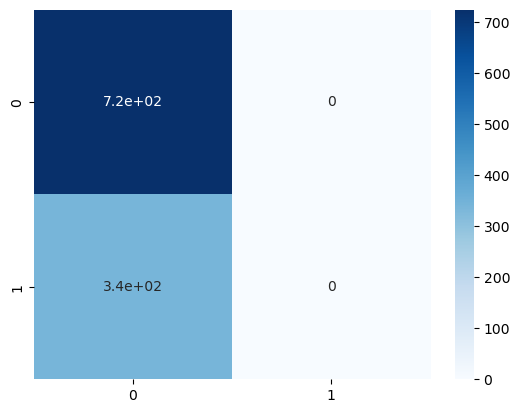

In [35]:
#IGNOR THIS BLOCK

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already trained and tested your model
y_pred = model.predict(x_test)
y_true = y_test.argmax(axis=1) # convert true labels to categorical format
cm = confusion_matrix(y_true, y_pred.argmax(axis=1))

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
